In [1]:
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
import plotly.express as px
import matplotlib.pyplot as plt
import umap.umap_ as umap
import nbformat

/Users/Jorge/Library/Caches/pypoetry/virtualenvs/lorawan-chatbot-rag-llm-Kbm_Xz7B-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embed_filename = "data/faq/qa-embeddings.tsv"

In [3]:
# Read the data from the file in data/faq/faq_cleaned.csv
df = pd.read_json("data/faq/fq.json")
df.head()
df.shape

(95, 2)

In [4]:
# Get only the questions
q_df = df[["question"]]
q_df.head()

,question
0,What is the purpose of a LoRaWAN network key (...
1,How does LoRaWAN handle different data rates?
2,What is the significance of the AppKey in LoRa...
3,How do LoRaWAN gateways synchronize with end d...
4,What is the role of the payload encryption in ...


In [5]:
embeddings = GeminiEmbedding(model_name="models/embedding-001")
def get_embeddings(text):
    return embeddings.get_text_embedding(text)
q_df['embeddings'] = q_df['question'].apply(lambda q: get_embeddings(str((q))))

In [6]:
q_df.head()
q_df.to_csv(embed_filename, sep="\t", index=False)

In [7]:
q_df = pd.read_csv(embed_filename, sep="\t")
q_df['embeddings'] = q_df.embeddings.apply(eval)
q_df.head()

,question,embeddings
0,What is the purpose of a LoRaWAN network key (...,"[0.02887409, -0.028092692, -0.081919245, -0.03..."
1,How does LoRaWAN handle different data rates?,"[0.04403216, -0.046490848, -0.07048576, 0.0221..."
2,What is the significance of the AppKey in LoRa...,"[0.035003267, -0.028232923, -0.06380164, -0.02..."
3,How do LoRaWAN gateways synchronize with end d...,"[0.0727575, -0.02746923, -0.05103394, 0.007169..."
4,What is the role of the payload encryption in ...,"[0.0660908, -0.03481021, -0.055927873, -0.0206..."


In [8]:
x = np.array(q_df['embeddings'].tolist())
print(x.shape)

(95, 768)


In [9]:
near_dup_threshold = 0.7
model = AgglomerativeClustering(n_clusters=None, distance_threshold=near_dup_threshold, linkage='average')
model = model.fit(x)

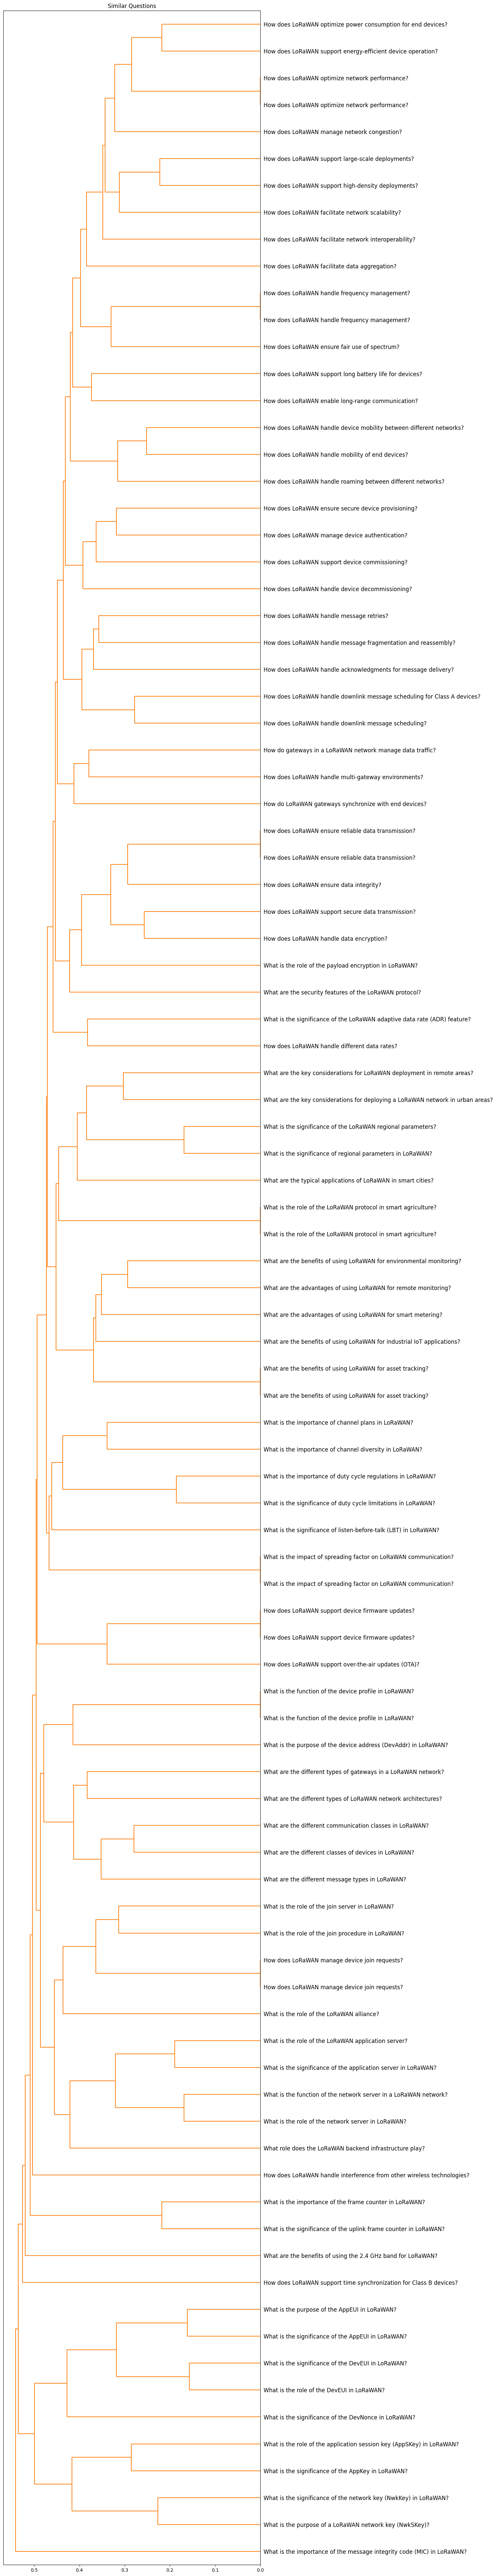

In [10]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
            counts[i] = current_count
            
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Plot the corresponding dendrogram)
    dendrogram(linkage_matrix, **kwargs)
plt.figure(figsize=(10,100))
plt.title('Similar Questions')
plot_dendrogram(
    model, 
    truncate_mode=None, 
    color_threshold=near_dup_threshold, 
    orientation='left', 
    labels=q_df['question'].tolist()
)
plt.yticks(fontsize=12)
plt.show()

In [11]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=near_dup_threshold)
q_df['cluster'] = model.fit_predict(x)
print(q_df['cluster'].value_counts())
print(model.n_clusters_)

cluster
0     18
3     16
1     10
4      8
2      7
12     6
8      6
10     5
5      4
7      4
11     4
6      4
9      3
Name: count, dtype: int64
13


In [12]:
q_df.head()

,question,embeddings,cluster
0,What is the purpose of a LoRaWAN network key (...,"[0.02887409, -0.028092692, -0.081919245, -0.03...",5
1,How does LoRaWAN handle different data rates?,"[0.04403216, -0.046490848, -0.07048576, 0.0221...",0
2,What is the significance of the AppKey in LoRa...,"[0.035003267, -0.028232923, -0.06380164, -0.02...",5
3,How do LoRaWAN gateways synchronize with end d...,"[0.0727575, -0.02746923, -0.05103394, 0.007169...",0
4,What is the role of the payload encryption in ...,"[0.0660908, -0.03481021, -0.055927873, -0.0206...",4


In [13]:
for cluster in q_df['cluster'].unique():
    print(f"Cluster {cluster}")
    print(q_df[q_df['cluster'] == cluster]['question'].values)
    print()

Cluster 5
['What is the purpose of a LoRaWAN network key (NwkSKey)?'
 'What is the significance of the AppKey in LoRaWAN?'
 'What is the role of the application session key (AppSKey) in LoRaWAN?'
 'What is the significance of the network key (NwkKey) in LoRaWAN?']

Cluster 0
['How does LoRaWAN handle different data rates?'
 'How do LoRaWAN gateways synchronize with end devices?'
 'How does LoRaWAN handle downlink message scheduling?'
 'How does LoRaWAN handle multi-gateway environments?'
 'How does LoRaWAN handle interference from other wireless technologies?'
 'How does LoRaWAN handle mobility of end devices?'
 'How does LoRaWAN handle message fragmentation and reassembly?'
 'How does LoRaWAN handle device mobility between different networks?'
 'How does LoRaWAN handle downlink message scheduling for Class A devices?'
 'How does LoRaWAN handle frequency management?'
 'What is the significance of the LoRaWAN adaptive data rate (ADR) feature?'
 'How does LoRaWAN handle acknowledgments f

In [14]:
dedup_filename = "data/faq/faq_deduped.tsv"

In [15]:
q_df.to_csv(dedup_filename, sep="\t", index=False)

In [16]:
q_df = pd.read_csv(dedup_filename, sep='\t')
q_df['embeddings'] = q_df.embeddings.apply(eval)
print(len(q_df))
q_df.head()

95


,question,embeddings,cluster
0,What is the purpose of a LoRaWAN network key (...,"[0.02887409, -0.028092692, -0.081919245, -0.03...",5
1,How does LoRaWAN handle different data rates?,"[0.04403216, -0.046490848, -0.07048576, 0.0221...",0
2,What is the significance of the AppKey in LoRa...,"[0.035003267, -0.028232923, -0.06380164, -0.02...",5
3,How do LoRaWAN gateways synchronize with end d...,"[0.0727575, -0.02746923, -0.05103394, 0.007169...",0
4,What is the role of the payload encryption in ...,"[0.0660908, -0.03481021, -0.055927873, -0.0206...",4


In [17]:
merged_df = pd.merge(
    df, 
    q_df.drop_duplicates(subset=['question']), 
    on='question', 
    how='left',
)
print(merged_df.shape)
merged_df.head()

(95, 4)


,question,answer,embeddings,cluster
0,What is the purpose of a LoRaWAN network key (...,The network key (NwkSKey) is used to secure co...,"[0.02887409, -0.028092692, -0.081919245, -0.03...",5
1,How does LoRaWAN handle different data rates?,LoRaWAN handles different data rates by using ...,"[0.04403216, -0.046490848, -0.07048576, 0.0221...",0
2,What is the significance of the AppKey in LoRa...,The AppKey is used during the Over-the-Air Act...,"[0.035003267, -0.028232923, -0.06380164, -0.02...",5
3,How do LoRaWAN gateways synchronize with end d...,LoRaWAN gateways synchronize with end devices ...,"[0.0727575, -0.02746923, -0.05103394, 0.007169...",0
4,What is the role of the payload encryption in ...,Payload encryption in LoRaWAN ensures that the...,"[0.0660908, -0.03481021, -0.055927873, -0.0206...",4


In [18]:
embeddings = np.array(merged_df['embeddings'].tolist())

umap_model = umap.UMAP(n_components=2, random_state=42, n_jobs=1)

reduced_embeddings = umap_model.fit_transform(embeddings)
reduced_embeddings.shape

(95, 2)

In [19]:
n_sample_questions = 75
kmeans = KMeans(n_clusters=n_sample_questions, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(embeddings)

In [20]:
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=['X', 'Y'])
merged_df = pd.concat([merged_df, reduced_embeddings_df], axis=1)
merged_df.head()

,question,answer,embeddings,cluster,X,Y
0,What is the purpose of a LoRaWAN network key (...,The network key (NwkSKey) is used to secure co...,"[0.02887409, -0.028092692, -0.081919245, -0.03...",12,12.631556,3.229380
1,How does LoRaWAN handle different data rates?,LoRaWAN handles different data rates by using ...,"[0.04403216, -0.046490848, -0.07048576, 0.0221...",2,15.127400,0.481719
2,What is the significance of the AppKey in LoRa...,The AppKey is used during the Over-the-Air Act...,"[0.035003267, -0.028232923, -0.06380164, -0.02...",22,12.019588,2.961187
3,How do LoRaWAN gateways synchronize with end d...,LoRaWAN gateways synchronize with end devices ...,"[0.0727575, -0.02746923, -0.05103394, 0.007169...",48,15.113661,1.592707
4,What is the role of the payload encryption in ...,Payload encryption in LoRaWAN ensures that the...,"[0.0660908, -0.03481021, -0.055927873, -0.0206...",62,13.164228,1.758660


In [21]:
df['manual quote'] = ''
merged_df['manual quote'] = ""

In [22]:
def select_one(df):
    if (df['manual quote'] != '').any():
        df = df[df['manual quote'] != '']
    return df.sample(n=1, random_state=42)

# Apply the function to each cluster group
merged_df = merged_df[['cluster', 'question', 'answer', 'manual quote']]
test_df = merged_df.groupby('cluster').apply(select_one, include_groups=False).reset_index(drop=True)
print(test_df.shape)
print(test_df[test_df['manual quote'] != ''].shape[0])
test_df.head()

(75, 3)
0


,question,answer,manual quote
0,How does LoRaWAN handle message fragmentation ...,LoRaWAN handles message fragmentation and reas...,
1,What is the significance of the LoRaWAN region...,LoRaWAN regional parameters define the frequen...,
2,How does LoRaWAN handle different data rates?,LoRaWAN handles different data rates by using ...,
3,How does LoRaWAN enable long-range communication?,LoRaWAN enables long-range communication using...,
4,What is the function of the network server in ...,The network server manages device registration...,


In [23]:
# Merge with an indicator and set how='outer' to see all rows in both dataframes
merged = merged_df.merge(test_df, on=['question', 'answer', 'manual quote'], how='left', indicator=True)

# retain rows that exist only in merged_df
train_df = merged[merged['_merge'] == 'left_only']

# drop 'cluster' column
train_df = train_df.drop(columns=['cluster', '_merge'])

print(train_df.shape)
train_df.head()

(11, 3)


,question,answer,manual quote
0,What is the purpose of a LoRaWAN network key (...,The network key (NwkSKey) is used to secure co...,
8,What is the significance of the uplink frame c...,The uplink frame counter helps prevent replay ...,
9,How does LoRaWAN support energy-efficient devi...,LoRaWAN supports energy-efficient operation th...,
22,What is the significance of the application se...,The application server processes and stores da...,
24,What is the role of the network server in LoRa...,The network server manages device registration...,


In [24]:
test_filename = 'data/faq/qa-test.tsv'
train_filename = 'data/faq/qa-train.tsv'

In [25]:
test_df.to_csv(test_filename, index=False, sep='\t')
train_df.to_csv(train_filename, index=False, sep='\t')

In [26]:
test_df = pd.read_csv(test_filename, sep='\t', na_filter=False)
print(test_df.shape)
test_df.head()

(75, 3)


,question,answer,manual quote
0,How does LoRaWAN handle message fragmentation ...,LoRaWAN handles message fragmentation and reas...,
1,What is the significance of the LoRaWAN region...,LoRaWAN regional parameters define the frequen...,
2,How does LoRaWAN handle different data rates?,LoRaWAN handles different data rates by using ...,
3,How does LoRaWAN enable long-range communication?,LoRaWAN enables long-range communication using...,
4,What is the function of the network server in ...,The network server manages device registration...,


In [27]:
train_df = pd.read_csv(train_filename, sep='\t', na_filter=False)
print(train_df.shape)
train_df.head()

(11, 3)


,question,answer,manual quote
0,What is the purpose of a LoRaWAN network key (...,The network key (NwkSKey) is used to secure co...,
1,What is the significance of the uplink frame c...,The uplink frame counter helps prevent replay ...,
2,How does LoRaWAN support energy-efficient devi...,LoRaWAN supports energy-efficient operation th...,
3,What is the significance of the application se...,The application server processes and stores da...,
4,What is the role of the network server in LoRa...,The network server manages device registration...,
